# Задание
Исследовать, от каких факторов зависит ценообразование на автомобили, выяснить, какие переменные важны для прогнозирования и насколько хорошо полученная модель описывает данные, выбрать, какую модель лучше оставить.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
df = pd.read_csv('cars.csv')
df

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,201,-1,volvo 145e (sw),gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0
201,202,-1,volvo 144ea,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0
202,203,-1,volvo 244dl,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0
203,204,-1,volvo 246,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

Использовать полное название машины – не самый хороший вариант, поэтому создадим новый признак – марку автомобиля (company)

In [4]:
df['company'] = df.CarName.apply(lambda x: x.split(' ')[0])

Колнки CarName и car_ID для дальнейшего анализа не нужны, удалим их из датасета

In [5]:
df = df.drop(columns=['CarName', 'car_ID']) 

Посмотрим на марки автомобилей и их количество

In [6]:
df.company.nunique()

28

In [7]:
df.company.unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'Nissan', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

Часть марок оказалась с ошибками, исправим это:

In [8]:
df.company = df.company.str.lower()

In [9]:
df.company = df.company.str.lower()
df.company.replace('maxda', 'mazda', inplace=True)
df.company.replace('porcshce', 'porsche', inplace=True)
df.company.replace('toyouta', 'toyota', inplace=True)
df.company.replace('vokswagen','volkswagen', inplace=True)
df.company.replace('vw','volkswagen', inplace=True)

Чтобы не перегружать модель большим количеством предикторов, оставим только часть из них:
* company
* fueltype
* aspiration
* carbody
* drivewheel 
* wheelbase 
* carlength
* carwidth
* curbweight
* enginetype
* cylindernumber
* enginesize
* boreratio
* horsepower

После этого посчитаем корреляцию между price и другими переменными.

In [10]:
cols_to_need = ['company', 'fueltype', 'aspiration','carbody', 'drivewheel', 'wheelbase', 'carlength','carwidth',
                'curbweight', 'enginetype', 'cylindernumber', 'enginesize', 'boreratio','horsepower', 'price']
df = df[cols_to_need]
df.corr()

,wheelbase,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,price
wheelbase,1.000000,0.874587,0.795144,0.776386,0.569329,0.488750,0.353294,0.577816
carlength,0.874587,1.000000,0.841118,0.877728,0.683360,0.606454,0.552623,0.682920
carwidth,0.795144,0.841118,1.000000,0.867032,0.735433,0.559150,0.640732,0.759325
curbweight,0.776386,0.877728,0.867032,1.000000,0.850594,0.648480,0.750739,0.835305
enginesize,0.569329,0.683360,0.735433,0.850594,1.000000,0.583774,0.809769,0.874145
boreratio,0.488750,0.606454,0.559150,0.648480,0.583774,1.000000,0.573677,0.553173
horsepower,0.353294,0.552623,0.640732,0.750739,0.809769,0.573677,1.000000,0.808139
price,0.577816,0.682920,0.759325,0.835305,0.874145,0.553173,0.808139,1.000000


Посмотрим корреляции между всеми переменными датасета и  их распределения.

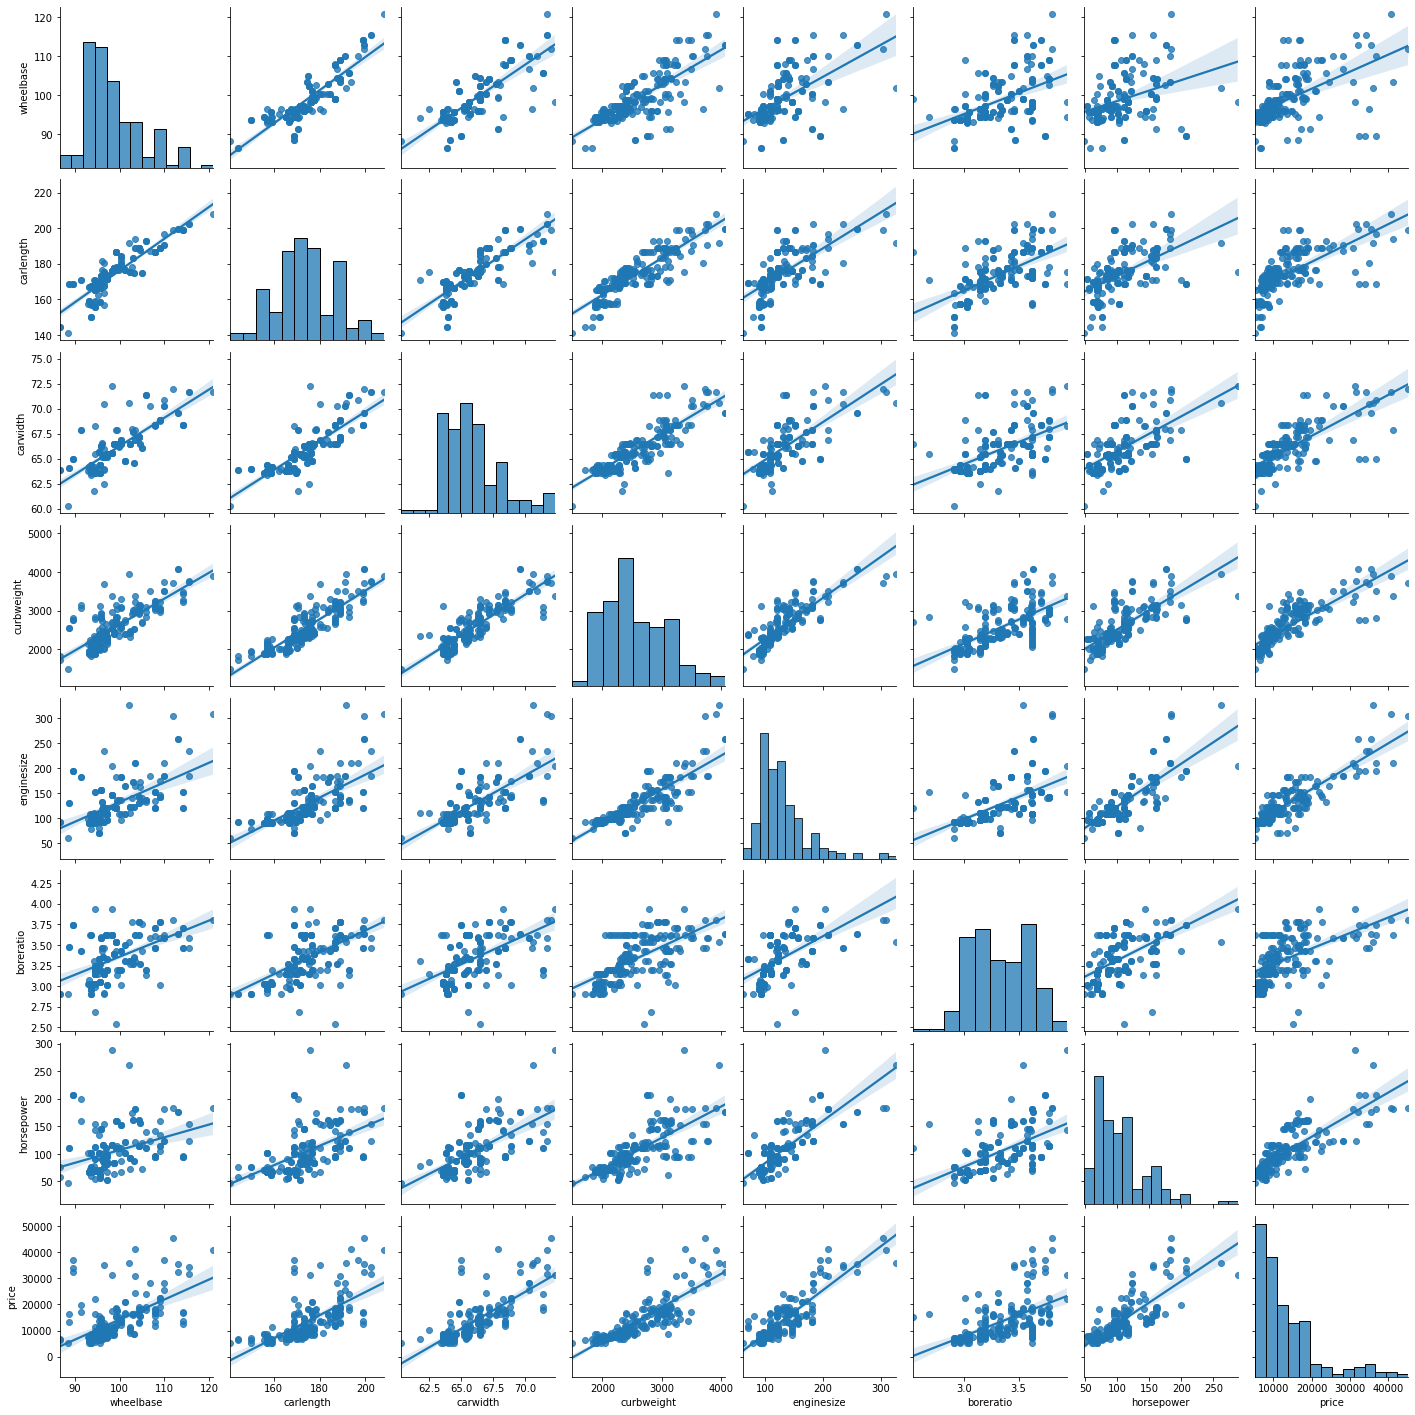

In [11]:
sns.pairplot(df, kind = 'reg')

Применим pd.get_dummies() для дальнейшей работы с категориальными переменным

In [12]:
df_dummy = pd.get_dummies(data=df[['fueltype', 'aspiration', 
                                   'carbody', 'drivewheel', 
                                   'enginetype', 'cylindernumber', 'company']], drop_first = True)

In [13]:
df_drop = df.drop(columns=['fueltype', 'aspiration', 'carbody', 'drivewheel', 'enginetype', 'cylindernumber', 'company']) 

In [14]:
cars = pd.concat([df_dummy, df_drop], axis=1)
cars

,fueltype_gas,aspiration_turbo,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_fwd,drivewheel_rwd,enginetype_dohcv,enginetype_l,...,company_volkswagen,company_volvo,wheelbase,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,price
0,1,0,0,0,0,0,0,1,0,0,...,0,0,88.6,168.8,64.1,2548,130,3.47,111,13495.0
1,1,0,0,0,0,0,0,1,0,0,...,0,0,88.6,168.8,64.1,2548,130,3.47,111,16500.0
2,1,0,0,1,0,0,0,1,0,0,...,0,0,94.5,171.2,65.5,2823,152,2.68,154,16500.0
3,1,0,0,0,1,0,1,0,0,0,...,0,0,99.8,176.6,66.2,2337,109,3.19,102,13950.0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,99.4,176.6,66.4,2824,136,3.19,115,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,1,0,0,0,1,0,0,1,0,0,...,0,1,109.1,188.8,68.9,2952,141,3.78,114,16845.0
201,1,1,0,0,1,0,0,1,0,0,...,0,1,109.1,188.8,68.8,3049,141,3.78,160,19045.0
202,1,0,0,0,1,0,0,1,0,0,...,0,1,109.1,188.8,68.9,3012,173,3.58,134,21485.0
203,0,1,0,0,1,0,0,1,0,0,...,0,1,109.1,188.8,68.9,3217,145,3.01,106,22470.0


Наиболее высокие коэффиценты корреляции цены с размером двигателя и мощностью, при этом корреляция последних друг с другом столь же высока.
Сначала построим небольшую модель всего с одним предиктором цены – размером двигателя (enginesize).

In [15]:
results = smf.ols('price ~ enginesize', cars).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     657.6
Date:                Tue, 26 Oct 2021   Prob (F-statistic):           1.35e-65
Time:                        09:34:58   Log-Likelihood:                -1984.4
No. Observations:                 205   AIC:                             3973.
Df Residuals:                     203   BIC:                             3979.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -8005.4455    873.221     -9.168      0.0

Добавим предиктор мощность.

In [16]:
X = cars[['enginesize', 'horsepower']]
X = sm.add_constant(X)
y = cars['price']
model_1 = sm.OLS(y, X).fit()
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     387.7
Date:                Tue, 26 Oct 2021   Prob (F-statistic):           6.93e-70
Time:                        09:35:00   Log-Likelihood:                -1970.9
No. Observations:                 205   AIC:                             3948.
Df Residuals:                     202   BIC:                             3958.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8389.7331    822.532    -10.200      0.0

Скорректированный R2 возрос, информационные критерии AIC/BIC снизились, вторая модель работает лучше. 

Теперь попробуем обратный путь - построим модель со всеми предикторами.

In [17]:
X = cars.drop(['price'], axis='columns')
X = sm.add_constant(X)
y = cars['price']
model_1 = sm.OLS(y, X).fit()
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     81.09
Date:                Tue, 26 Oct 2021   Prob (F-statistic):           4.86e-89
Time:                        09:35:01   Log-Likelihood:                -1804.2
No. Observations:                 205   AIC:                             3702.
Df Residuals:                     158   BIC:                             3858.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -3.472e+

И модель со всеми предикторами, кроме марок машин:

In [18]:
cols_to_keep = cars.columns[~cars.columns.str.startswith('company_')]
cols_to_keep

Index(['fueltype_gas', 'aspiration_turbo', 'carbody_hardtop',
       'carbody_hatchback', 'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd',
       'drivewheel_rwd', 'enginetype_dohcv', 'enginetype_l', 'enginetype_ohc',
       'enginetype_ohcf', 'enginetype_ohcv', 'enginetype_rotor',
       'cylindernumber_five', 'cylindernumber_four', 'cylindernumber_six',
       'cylindernumber_three', 'cylindernumber_twelve', 'cylindernumber_two',
       'wheelbase', 'carlength', 'carwidth', 'curbweight', 'enginesize',
       'boreratio', 'horsepower', 'price'],
      dtype='object')

In [19]:
X = cars[cols_to_keep].drop(['price'], axis='columns')
X= sm.add_constant(X)
y = cars['price']
model_2 = sm.OLS(y, X).fit()
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     72.32
Date:                Tue, 26 Oct 2021   Prob (F-statistic):           9.86e-81
Time:                        09:35:05   Log-Likelihood:                -1881.6
No. Observations:                 205   AIC:                             3817.
Df Residuals:                     178   BIC:                             3907.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -1.7e+

По последним двум моделям видим, что при изъятии из модели параметра "марка автомобиля" скорректированный коэффициент R2 снизился несущественно (большая часть марок вообще не вносит значисмоти в работу модели), информационные критерии AIC и BIC среди рассчитаных нами моделей минимальны для последней, значит выбираем для прогноза вторую модель, объясняющую ~91% изменчивости цены. 